



# Facial Expression Recognition with TensorFlow CNN

## Problem Statement: 
## The task is to categorize each face (images) based on the emotion shown in the facial expression in to one of seven categories 

#### 0=Angry 
#### 1=Disgust 
#### 2=Fear
#### 3=Happy
#### 4=Sad
#### 5=Surprise
#### 6=Neutral

## Method: Use CNN model to conduct images classification
#### Detailed CNN structure is showed below

## Challenges in Representation Learning - Facial Expression Recognition Challenge:  https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D 
from keras.utils import np_utils
#from keras import backend as K
from keras.regularizers import l1, activity_l1
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Using TensorFlow backend.


#### The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

# Data inspection

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
train.head()

,Unnamed: 0,emotion,pixels,Usage
0,17092,0,8 7 6 5 5 5 5 3 4 5 4 3 3 7 5 6 7 7 8 7 4 0 0 ...,Training
1,8965,0,46 58 76 56 47 43 32 29 22 22 29 20 17 26 22 2...,Training
2,6024,0,179 178 225 218 216 215 217 220 222 224 225 22...,Training
3,6270,0,219 117 182 186 138 135 146 151 157 163 156 15...,Training
4,19268,0,70 69 84 85 93 101 118 146 156 152 153 157 159...,Training


In [5]:
print ("The number of traning set samples: {}".format(len(train)))
print ("The number of testing set samples: {}".format(len(test)))

The number of traning set samples: 3052
The number of testing set samples: 777


In [6]:
print ("Training dataset emotion and its count")
train.emotion.value_counts()

Training dataset emotion and its count


5    436
3    436
1    436
6    436
4    436
2    436
0    436
Name: emotion, dtype: int64

In [7]:
print ("Testing dataset emotion and its count")
test.emotion.value_counts()

Testing dataset emotion and its count


6    111
5    111
4    111
3    111
2    111
1    111
0    111
Name: emotion, dtype: int64

In [8]:
#this function is to plot any certain emotion in certain dataset randomly
def Plot_SomeEmotion_Sample_Randomly(emotion, dataset):
    #select certain emotion sub dataset
    EmotionSet = dataset[dataset.emotion == emotion]
    #randomly select one sample
    pixels_list = EmotionSet.sample(1).pixels.str.split(" ").tolist()
    #convert to 48*48 format
    show_image = np.array(pixels_list, dtype=float).reshape(48,48)
    #plot the image
    plt.imshow(show_image, cmap='gray')

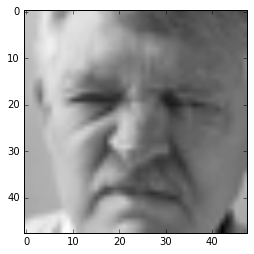

In [15]:
#plot randomly disgust image
Plot_SomeEmotion_Sample_Randomly(1, train)

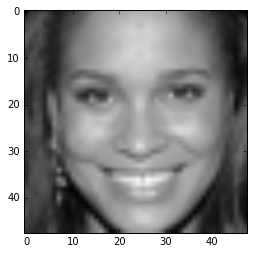

In [17]:
#plot randomly happy image
Plot_SomeEmotion_Sample_Randomly(3, train)

# Data pre-processing

In [5]:
#convert flatten data to 48*48 matrix
def reshapeTo48and48(dataset):
    #extract pixels value from original pandas dataframe
    pixels_values = dataset.pixels.str.split(" ").tolist()
    #convert pixels of each image to 48*48 formats
    images = []
    for image in np.array(pixels_values, dtype=float):
        images.append(image.reshape(48, 48))
    return np.array(images, dtype=float)

In [6]:
train_images = reshapeTo48and48(train)
test_images = reshapeTo48and48(test)

In [20]:
#reshape to [# of samples][width][height][pixels] for tensorflow-keras input format
train_images = train_images.reshape(train_images.shape[0], 48, 48, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 48, 48, 1).astype('float32')

In [21]:
#check input format
train_images.shape

(3052, 48, 48, 1)

In [25]:
#normilize the data
train_images = train_images/255
test_images = test_images/255

In [26]:
#One hot encode outputs: change target(emotion) values to input format with one-hot encode
train_targets = np_utils.to_categorical(train.emotion.values)
test_targets = np_utils.to_categorical(test.emotion.values)

In [27]:
#set number of prediction classes
num_classes = test_targets.shape[1]

# Build the CNN model

### 1. Documents on CNN layers:

#### Keras Sequential model introduction: https://keras.io/getting-started/sequential-model-guide/

#### Dropout is a technique where randomly selected neurons are ignored during training
#### Dropout API: https://keras.io/layers/core/#dropout

#### Convolution2D API: https://keras.io/layers/convolutional/#convolution2d

#### MaxPooling2D API: https://keras.io/layers/pooling/#maxpooling2d

#### MaxPooling2D API: https://keras.io/layers/pooling/#maxpooling2d

#### Dense (Locally Connected Layer) API: https://keras.io/layers/core/#dense

#### Flatten API: https://keras.io/layers/core/#flatten

### 2. Structure of below CNN:

##### Input
##### Dropout layer
##### Convolution layer + relu layer
##### Max pooling layer
##### Convolution layer + relu layer
##### Max pooling layer
##### Dropout layer
##### Fully connected layer (dense)
##### Dropout layer
##### Fully connected layer (dense)
##### classifier

In [28]:
def sample_model():
    #initial model
    model = Sequential()
    #add dropout to reduce overfitting
    model.add(Dropout(0.2, input_shape=(48, 48, 1)))
    #with 64 filters, 5*5 for convolutional kernel and activation 'relu'
    model.add(Convolution2D(64, 5, 5, input_shape=(48, 48, 1), activation='relu'))
    #pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    #fully connected layer
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, W_regularizer=l1(0.01), 
                    activity_regularizer=activity_l1(0.01), 
                    activation='softmax'))
    return model

In [29]:
model = sample_model()

##### If you want to train and save the model, you could run next three parts of code. It may take 30 minutes, which depend on your computer

In [30]:
#set information for saveing model
filename = "MyBestModel.hdf5"
check_point = ModelCheckpoint(filename, monitor='val_acc', verbose=2, save_best_only=True,
                              mode='max')
callbacks_list = [check_point]

In [31]:
#training model
##complie
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
##begin to train and save training history
history = model.fit(train_images, train_targets, validation_data=(test_images, test_targets), 
          nb_epoch=2, batch_size=80, callbacks=callbacks_list, verbose=2)

Train on 3052 samples, validate on 777 samples
Epoch 1/2
Epoch 00000: val_acc improved from -inf to 0.18275, saving model to MyBestModel.hdf5
67s - loss: 3.8118 - acc: 0.1356 - val_loss: 3.5653 - val_acc: 0.1828
Epoch 2/2
Epoch 00001: val_acc improved from 0.18275 to 0.21750, saving model to MyBestModel.hdf5
61s - loss: 3.4070 - acc: 0.1694 - val_loss: 3.2178 - val_acc: 0.2175


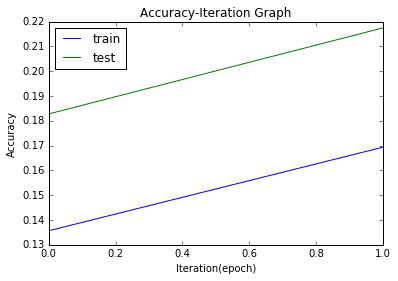

In [32]:
# plot history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy-Iteration Graph')
plt.ylabel('Accuracy')
plt.xlabel('Iteration(epoch)')
plt.legend(['train',  'test'], loc='upper left')
plt.show()                                                                                          

# Continue to train the prior saved model
### To save our time, we can reload the weights of prior trained model and continue to train with same or different CNN model

In [ ]:
#you can design the CNN structure by changing below CNN structure
def continued_model():
    #initial model
    model = Sequential()
    #add dropout to reduce overfitting
    model.add(Dropout(0.2, input_shape=(48, 48, 1)))
    #with 64 filters, 5*5 for convolutional kernel and activation 'relu'
    model.add(Convolution2D(64, 5, 5, input_shape=(48, 48, 1), activation='relu'))
    #pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    #fully connected layer
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, W_regularizer=l1(0.01), 
                    activity_regularizer=activity_l1(0.01), 
                    activation='softmax'))
    return model

In [20]:
continued_model = continued_model()

In [22]:
continued_model.load_weights('BestModel.hdf5')

In [24]:
#set information for saveing model
filename = "MyContinuedBestModel.hdf5"
check_point = ModelCheckpoint(filename, monitor='val_acc', verbose=2, save_best_only=True,
                              mode='max')
callbacks_list = [check_point]

In [28]:
##complie
continued_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
##begin to train and save training history
continued_history = continued_model.fit(train_images, train_targets, validation_data=(test_images, test_targets), 
                                        nb_epoch=5, batch_size=80, callbacks=callbacks_list, verbose=2)

Train on 3052 samples, validate on 777 samples
Epoch 1/5
Epoch 00000: val_acc improved from -inf to 0.35650, saving model to MyContinuedBestModel.hdf5
73s - loss: 1.9966 - acc: 0.5855 - val_loss: 2.5017 - val_acc: 0.3565
Epoch 2/5
Epoch 00001: val_acc improved from 0.35650 to 0.38610, saving model to MyContinuedBestModel.hdf5
69s - loss: 1.9514 - acc: 0.5944 - val_loss: 2.5026 - val_acc: 0.3861
Epoch 3/5
Epoch 00002: val_acc did not improve
92s - loss: 1.9053 - acc: 0.6222 - val_loss: 2.5159 - val_acc: 0.3668
Epoch 4/5
Epoch 00003: val_acc did not improve
78s - loss: 1.8569 - acc: 0.6350 - val_loss: 2.5223 - val_acc: 0.3810
Epoch 5/5
Epoch 00004: val_acc did not improve
95s - loss: 1.8493 - acc: 0.6389 - val_loss: 2.5474 - val_acc: 0.3784


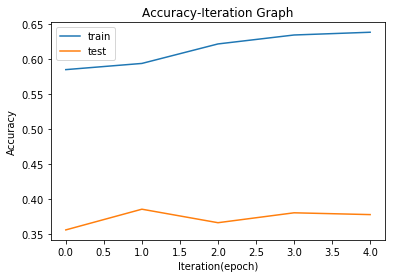

In [29]:
# plot history for accuracy
plt.plot(continued_history.history['acc'])
plt.plot(continued_history.history['val_acc'])
plt.title('Accuracy-Iteration Graph')
plt.ylabel('Accuracy')
plt.xlabel('Iteration(epoch)')
plt.legend(['train',  'test'], loc='upper left')
plt.show() 

# Load saved trained model & show the final analysis

In [46]:
#build a saved_model and load weights
Saved_model = sample_model()
Saved_model.load_weights("BestModel2.hdf5")
Saved_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
#get loss value and accuracy for testing set
scores = Saved_model.evaluate(test_images, test_targets, verbose=0)

In [50]:
#print accuracy
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 37.19%


### Draw confusion matric to evaluate the final model

In [53]:
Saved_prediction = Saved_model.predict_classes(test_images, verbose=0)

In [58]:
True_prediction = test.emotion.values

In [62]:
cm = confusion_matrix(True_prediction, Saved_prediction)

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[21 17 17 13 30  5  8]
 [ 7 67 11 10 10  3  3]
 [ 9 11 18 12 36 16  9]
 [ 6  8  5 61 19  4  8]
 [19 11 10 19 39  5  8]
 [ 6  7 15  9 14 59  1]
 [ 4 15 15 17 30  6 24]]


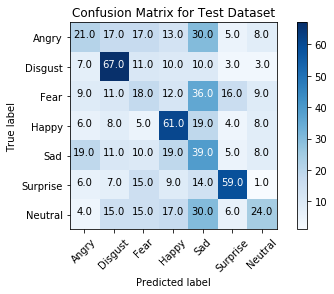

In [65]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title='Confusion Matrix for Test Dataset')
plt.show()